In [1]:
import sys
import os
import math
import numpy as np
import functools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize
import seaborn as sns
import pandas as pd
from sklearn.calibration import calibration_curve

sys.path.append("../src")
from logistic_regression import *

%matplotlib notebook

In [2]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (13,10)

# Problem 2

The empirical risk is given by $\mathbf{E}[\ell(y, \hat{y}) | x]$, where the expectation is taken over $y$. For a margin based loss function, we have the form $\mathbf{E}[\ell(y\hat{y}) | x]$

### Problem 2.1

If our prediction is given by $\hat{y} = f(x)$ and $\pi(x) = p(y=1|x)$ then we can write the empirical risk as 

$$
\begin{align*}
\mathbf{E}[\ell(yf(x)|x] &= p(y=1|x)\ell(f(x)) + p(y=-1|x)\ell(-f(x))\\
&= \pi(x)\ell(f(x)) + (1-\pi(x))\ell(-f(x))\\
&= \ell(-f(x)) + \pi(x)(\ell(f(x)) - \ell(-f(x))
\end{align*}
$$

### Problem 2.2

The exponential loss is given by $\ell(y,f(x)) = e^{-yf(x)}$. Using the result of 2.1 we have 

$$
\begin{align*}
\mathbf{E}[\ell(yf(x)|x] &= e^{f(x)} + \pi(x)(e^{-f(x)} - e^{f(x)})\\
\end{align*}
$$

For a fixed $x$ we can differentiate wrt to $f(x)$ to find the empirical risk minimizer

$$
\begin{align*}
0 &= \frac{d}{df(x)}\left[e^{f(x)} + \pi(x)(e^{-f(x)} - e^{f(x)})\right]\\
0 &= e^{f(x)} + \pi(x)\left(-e^{-f(x)} - e^{f(x)}\right)\\
\pi(x) &= \frac{-e^{f(x)}}{y\left(-e^{-f(x)} - e^{f(x)}\right)}\\
\pi(x) &= \frac{1}{\left(e^{-2f(x)} + 1\right)}\\
\end{align*}
$$

The optimal prediction function can be solved from the conditional probability

$$
\begin{align*}
\pi(x) &= \frac{1}{\left(e^{-2f(x)} + 1\right)}\\
\frac{1}{\pi(x)} -1 &= e^{-2f(x)}\\
-2f(x) &= \log\left(\frac{1 - \pi(x)}{\pi(x)}\right)\\
f(x) &= \frac{1}{2}\log\left(\frac{\pi(x)}{1 - \pi(x)}\right)\\
\end{align*}
$$

### Problem 2.3

The logistic loss function is given by $\ell(y, f(x)) = \log\left(1+e^{-yf(x)}\right)$. Using 2.1 we can again write the empirical risk minimizer as 

$$
\begin{align*}
\mathbf{E}[\ell(yf(x))|x] &= \log(1+e^{f(x)}) + \pi(x)\left[\log(1+ e^{-f(x)}) - \log(1+e^{f(x)})\right]\\
\end{align*}
$$

Taking the derivative wrt to $f(x)$ we find the conditional probability of the empirical risk minimizer

$$
\begin{align*}
0 &= \frac{e^{f(x)}}{1+e^{f(x)}} + \pi(x)\left[\frac{-e^{-f(x)}}{1+e^{-f(x)}} - \frac{e^{f(x)}}{1+e^{f(x)}}\right]\\
\frac{-e^{f(x)}}{1+e^{f(x)}} &= \pi(x)\left[\frac{-e^{-f(x)}}{1+e^{-f(x)}} - \frac{1}{1+e^{-f(x)}}\right]\\
\pi(x) &= \frac{1}{1+e^{-f(x)}}
\end{align*}
$$

### Problem 2.4

The hinge loss is given by $\ell(y, f(x)) = \max(0, 1- yf(x))$. From 2.1 we have the empirical risk

$$
\begin{align*}
\mathbf{E}[\ell(yf(x))|x] &= (1-\pi(x))\max(0, 1 + f(x)) + \pi(x)\max(0, 1 - f(x))\\
\end{align*}
$$

As a function of $f(x)$ (what we optimize over) is discontinuous only at the $1$ and $-1$. Below are some plots of the empirical risk for various values of $\pi(x)$

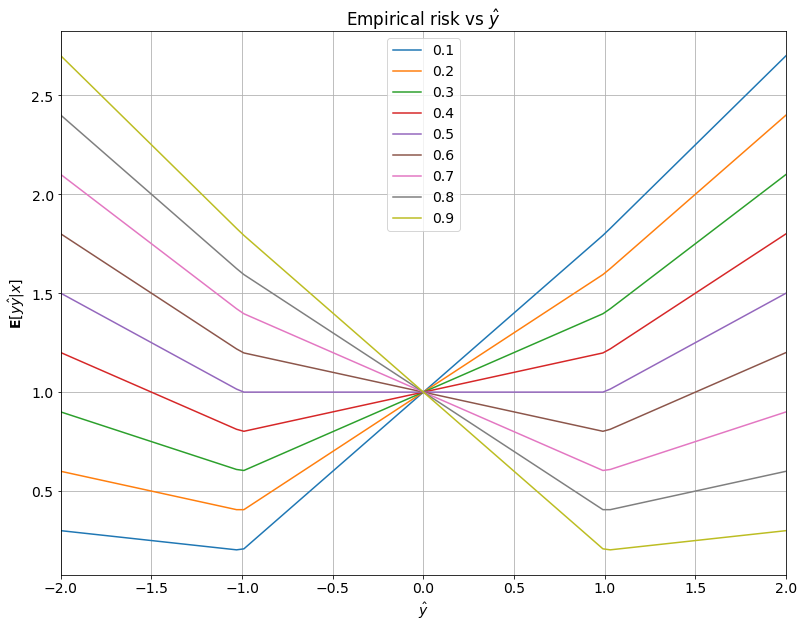

In [3]:
yhat_min = -2
yhat_max = 2
p = np.arange(0.1, 1, 0.1)
yhat_plot_vals = np.linspace(yhat_min, yhat_max, 100)

def empirical_risk_hinge_loss(x, p):
    return (1 - p) * np.maximum(0, 1 + x) + p * np.maximum(0, 1 - x)

for prob in p:
    empirical_risk = functools.partial(empirical_risk_hinge_loss, p=prob)
    plt.plot(yhat_plot_vals, empirical_risk(yhat_plot_vals), label=f'{prob:0.2}')

plt.title(r'Empirical risk vs $\hat{y}$');
plt.xlabel(r'$\hat{y}$');
plt.ylabel(r'$\mathbf{E}[y\hat{y}|x]$');
plt.xlim([yhat_min, yhat_max]);
plt.legend();

From the graphs of empirical risk as a function of the prediction, it's clear the minimum will always be attained at a discontinuity. Specifically, $-1$ or 1. The optimization problem then becomes a simple discrete minimization.

$$
\begin{align*}
f^{\star}(x) &= \arg \min_{\hat{y}\in \{-1,1\}} (1-\pi(x))\max(0, 1 + \hat{y}) + \pi(x)\max(0, 1 - \hat{y}) \\
\end{align*}
$$

Evaluating the function for both $-1$ and $1$ we get values $2\pi(x)$ and $2(1-\pi(x))$ respectively. So if $\pi(x) > 0.5$ then we choose $1$ (since we are _minimizing_ the empirical risk) and $-1$ otherwise. More succintly,

$$f^\star(x) = \mathbf{sign}(\pi(x) - 1/2)$$

### Problem 3.1

Defining the empirical risk of for the logistic loss as 

$$ \hat{R}_n(w) =\frac{1}{n}\sum_{i=1}^n \log(1+\text{exp}(-y_iw^Tx_i))$$

where $y_i \in \{-1,1\}$ we can compare with the negative log likelihood with $y_i'\in\{0,1\}$ which is defined as 

$$
\begin{align*}
\ell(w) &= \sum_{i=1}^n - y_i'\log(\phi(w^Tx_i)) + (y_i'-1)\log(1-\phi(w^Tx_i))\\
&= \sum_{i=1}^n y_i'\log(1+\text{exp}(-w^Tx_i)) - (y_i'-1)\log(1+\text{exp}(w^Tx_i))\\
&= \sum_{i=1}^n \log(1+\text{exp}(-(2y_i'-1)w^Tx_i))\\
&= \sum_{i=1}^n \log(1+\text{exp}(-y_iw^Tx_i))\\
\end{align*}
$$

This demonstrates $\ell(w) = n\hat{R}_n(w)$

### Problem 3.2

The log-sum-exp function is defined as $ f(x) = \log(\sum_{i=1}^n e^x_i)$. Defining $x^* = \max(x_1,x_2,\ldots,x_n)$ then $f(x) = \log(e^{x^*}\sum_{i=1}^n e^{x_i-x*}) = \log(e^{x^*}) + \log(\sum_{i=1}^n e^{x_i-x*}) =x^* + \log(\sum_{i=1}^n e^{x_i-x*})$.

Since $x_i-x^*\le0$ by virtue of $x^*$ being the maximum, we have immediately that $e^{x_i-x^*}\in(0,1]$. This further ensures the _log_ portion will never be negative infinity since we will always have one term in the sum equal to 1.

### Problem 3.3

The logistictic regression function with target $y\in \{-1,1\}$ is given by 

$$J(w) = \lambda ||w||^2 + \frac{1}{n} \sum_{i=1}^n \log (1 + \text{exp}(-y_iw^Tx_i))$$

We can show this function is convex by finding the hessian and proving it is positive semidefinite. The total derivative is given by 

$$
\begin{align*}
DJ &= 2\lambda w^T + \frac{1}{n} \sum_{i=1}^n \frac{1}{1 + \text{exp}(-y_iw^Tx_i)}\cdot \text{exp}(-y_iw^Tx_i) \cdot (-y_ix_i^T) \\
\nabla J &= \lambda w + \frac{1}{n}\sum_{i=1}^n \frac{1}{1 + \text{exp}(y_iw^Tx_i)} \cdot (-y_ix_i) \\
&= 2\lambda w - \frac{1}{n}\sum_{i=1}^n \sigma(-y_iw^Tx_i) \cdot (y_ix_i) \\
&= 2\lambda w - \frac{1}{n}\sum_{i=1}^n \left(1-\sigma(y_iw^Tx_i)\right) \cdot (y_ix_i) \\
D(\nabla J) &= 2\lambda I + \frac{1}{n}\sum_{i=1}^n \sigma(y_iw^Tx_i)\left(1-\sigma(y_iw^Tx_i)\right) \cdot (y_ix_i)D(y_iw^Tx_i) \\
&= 2\lambda I + \frac{1}{n}\sum_{i=1}^n \sigma(y_iw^Tx_i)\left(1-\sigma(y_iw^Tx_i)\right) \cdot (y^2_ix_ix_i^T)\\
&= 2\lambda I + \frac{1}{n}\sum_{i=1}^n \sigma(y_iw^Tx_i)\left(1-\sigma(y_iw^Tx_i)\right) \cdot (x_ix_i^T)\\
&= 2\lambda I + X^T\mathbf{diag}\left(\sigma(y_1w^Tx_1)\left(1-\sigma(y_1w^Tx_1)\right),\ldots,\sigma(y_nw^Tx_n)\left(1-\sigma(y_nw^Tx_n)\right)\right)X\\
&= 2\lambda I + X^TWX\\
\end{align*}
$$
where $X\in \mathbf{R}^{n\times d}$

We can easily verify this matrix to be PSD 
$$
\begin{align*}
z^T(HJ)z &= z^T\left(2\lambda I + X^TWX\right)z\\
&= 2\lambda ||z||^2 + z^TX^TWXz\\
&= 2\lambda ||z||^2 + ||W^{1/2}Xz||^2\\
&\ge 0
\end{align*}
$$

In [4]:
X_train = np.loadtxt(os.path.join('..', 'data', 'X_train.txt'),delimiter=',')
y_train = 2* np.loadtxt(os.path.join('..', 'data', 'y_train.txt')) - 1

X_val = np.loadtxt(os.path.join('..', 'data', 'X_val.txt'),delimiter=',')
y_val = 2 * np.loadtxt(os.path.join('..', 'data', 'y_val.txt')) - 1

In [5]:
regularization_path = 10 ** np.linspace(-3,1, 100) 
validation_loss = np.zeros_like(regularization_path)

w = np.zeros_like(X_train[0,:])
best_loss = np.infty
best_w = None
best_lambda = -1.0
for i, lam in enumerate(regularization_path):
    w = fit_logistic_reg(X_train, y_train, log_loss, l2_param=lam, theta_init=w)
    validation_loss[i] = log_loss(w, X_val, y_val, l2_param=0)

    if validation_loss[i] < best_loss:
        best_w = w
        best_lambda = lam
        best_loss = validation_loss[i]

print('Optimal regularization: {0:.3E}'.format(best_lambda))

Optimal regularization: 3.126E-02


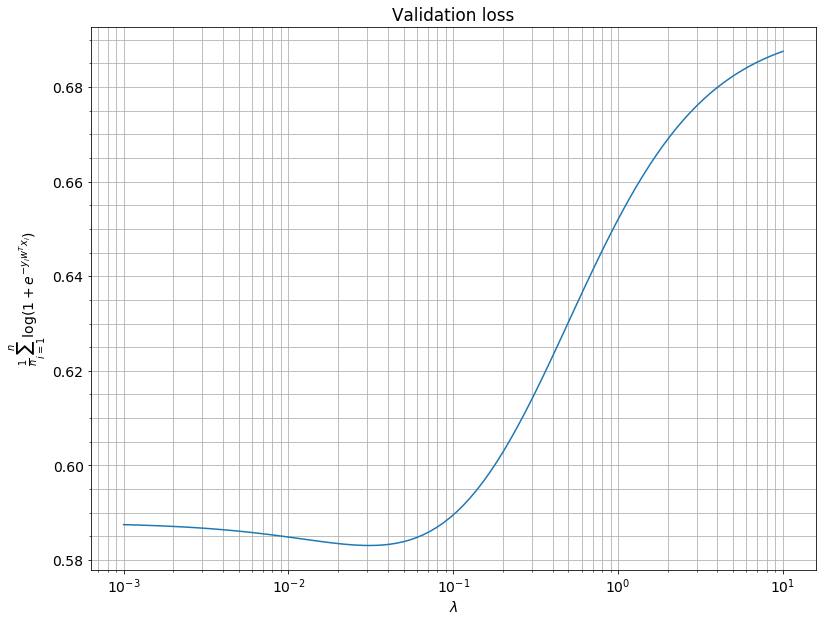

In [6]:
plt.semilogx(regularization_path, validation_loss)
plt.title('Validation loss')
plt.xlabel(r'$\lambda$')
plt.ylabel(r'$\frac{1}{n}\sum_{i=1}^n \log\left(1+e^{-y_iw^Tx_i}\right)$', fontsize=14)
plt.grid(True, which='minor')
plt.minorticks_on()
plt.show()


In [7]:
prob_class_1 = 1.0/(1 + np.exp(-X_val.dot(best_w)))
prob_true, prob_pred = calibration_curve(y_val, prob_class_1, n_bins=10)

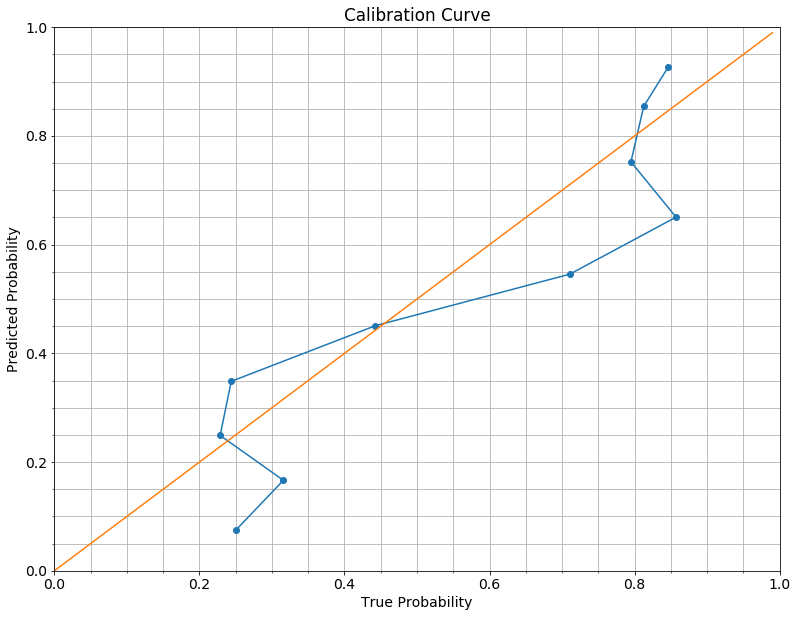

In [8]:
plt.plot(prob_true, prob_pred,marker='o')
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01))
plt.title('Calibration Curve')
plt.xlabel(r'True Probability')
plt.ylabel(r'Predicted Probability', fontsize=14)
plt.grid(True, which='minor')
plt.minorticks_on()

plt.xlim([0,1]);
plt.ylim([0,1]);
plt.show();

## Problem 4.1

The posterior density of the parameters is given by 

\begin{align*}
\log(p(w|D')) &= \log(p(D'|w)p(w)) - \log(p(D'))\\
&= \log(p(D'|w)) + \log(p(w)) - \log(p(D'))\\
&= \log\left(\prod_{i=1}^n \phi(w^Tx_i)^{y_i}(1-\phi(w^Tx_i)^{1-y_i}\right) + \log(p(w)) - \log(p(D'))\\
&= \sum_{i=1}^n \log\left(\phi(w^Tx_i)^{y_i}(1-\phi(w^Tx_i)^{1-y_i}\right) + \log(p(w)) - \log(p(D'))\\
&= \sum_{i=1}^n \left[y_i\log\left(\phi(w^Tx_i)+(1-y_i)\log(1-\phi(w^Tx_i)\right)\right] + \log(p(w)) - \log(p(D'))\\
\end{align*}

## Problem 4.2

Given a prior of the form
$$p(w) = \frac{1}{(2\pi)^{n/2}|\Sigma|^{1/2}}\text{exp}(-1/2\cdot w^T\Sigma^{-1}w) $$
we plug into the previous formula and drop constant terms

$$
\begin{align*}
\text{maximize}\quad \sum_{i=1}^n \left[y_i\log\left(\phi(w^Tx_i)+(1-y_i)\log(1-\phi(w^Tx_i)\right)\right] -0.5\cdot w^T\Sigma^{-1}w\\
\end{align*}
$$

To make this equivalent to the problem in 3.3, we multiply by $-1/n$ and minimize
$$
\begin{align*}
\text{minimize}\quad -\frac{1}{n}\sum_{i=1}^n \left[y_i\log\left(\phi(w^Tx_i)+(1-y_i)\log(1-\phi(w^Tx_i)\right)\right]+0.5/n\cdot w^T\Sigma^{-1}w\\
\end{align*}
$$
choosing $\Sigma^{-1} = n\lambda I$ makes the problems equivalent

## Problem 4.3

If we choose prior $p(w) \sim \mathcal{N}(0,I)$ then we must choose $\lambda = 1/n$ for an equaivalent Tikanov regularization problem.

## Problem 6.1

Given an observed sequence of heads and tails $\mathcal{D} = (H,H,T)$ the likelihood of the data is $p(\mathcal{D}|\theta) = \theta^2(1-\theta)$ where $\theta$ is the probability of heads.

## Problem 6.2

The probability of 2 heads and 1 tails is $\binom{3}{2}$

## Problem 6.3

The likelihood of a given sequence of $n_H$ heads and $n_t$ tails is given by $p(\mathcal{D}|\theta) = \theta^{n_H}(1-\theta)^{n_t}$

## Problem 6.4

The maximimum likelihood given an observed sequence of heads and tails is given by differentitating wrt the parameter
$$
\begin{align*}
\frac{d}{d\theta} \log (p(D|\theta)) &= \frac{d}{d\theta} \left(n_H\log(\theta) + n_t\log(1-\theta)\right)\\
0 &= n_H/\theta - n_t/(1-\theta)\\
0 &= n_H/\theta - n_t/(1-\theta)\\
0 &= n_H(1-\theta) - n_t\theta\\
\theta^\star &= \frac{n_H}{n_H+n_t}
\end{align*}
$$

### Problem 7.1

Given a prior distribution $p(\theta) \propto \theta^{h-1}(1-\theta)^{t-1}$, observing $n_t$ tails and $n_h$ heads the posterior is 

$$
\begin{align*}
p(\theta|\mathcal{D}) &= p(\mathcal{D}|\theta)p(\theta)/p(\mathcal{D})\\
&= \theta^{n_h}(1-\theta)^{n_t}\theta^{h-1}(1-\theta)^{t-1}/p(\mathcal{D})\\
&= \theta^{n_h + h -1}(1-\theta)^{n_t + t -1}/p(\mathcal{D})\\
&\sim \text{Beta}(n_h+h,n_t+t)
\end{align*}
$$

### Problem 7.2

The MLE estimate is given by 
$$
\begin{align*}
\theta_{MLE} &= \arg \max \theta^{n_h}(1-\theta)^{n_t}\\
&= \arg \max \log(\theta^{n_h}(1-\theta)^{n_t})\\
&= \frac{n_h}{n_h+n_t}\\
\end{align*}
$$

The MAP estimate is given by 

$$
\begin{align*}
\theta_{MAP} &= \arg \max \theta^{n_h+h-1}(1-\theta)^{n_t+t-1}\\
&= \arg \max \log(\theta^{n_h+h-1}(1-\theta)^{n_t+t-1})\\
&= \frac{n_h+h-1}{n_h+n_t+h+t-2}\\
\end{align*}
$$

The posterior mean of $\text{Beta}(n_h+h,n_t+t)$ is $\frac{n_h+h}{n_h+n_t+h+t}$

### Problem 7.3

As the total number of coinflips $n_t+n_h$ tends to infinity for a fixed ratio $n_h/(n_h+n_t)$ the posterior mean, MAP, and MLE estimates all converge to the same value of $n_h/(n_h+n_t)$

### Problem 8.1

For app $i$, given $x_i$ clicks and $n_i$ impressions and a click probability $\theta_i$ then the conditional probability of the data is 

$$p(\mathcal{D_i}|\theta_i) = \theta_i^{x_i}(1-\theta_i)^{n_i-x_i}$$

Using a prior $p(\theta_i) = B(\theta_i;a,b)$ we can write the posterior as 
$$ 
\begin{align*}
p(\theta_i|\mathcal{D}_i) &= \frac{p(\mathcal{D}_i|\theta_i)p(\theta_i)}{B(\theta_i;a+x_i,b+n_i-x_i)}\\
&= \frac{\theta_i^{x_i}(1-\theta_i)^{n_i-x_i}\theta_i^{a-1}(1-\theta_i)^{b-1}}{B(\theta_i;a+x_i,b+n_i-x_i)}\\
&= \frac{\theta_i^{x_i+a-1}(1-\theta_i)^{b+n_i-x_i-1}}{B(\theta_i;a+x_i,b+n_i-x_i)}\\
\end{align*}
$$

The marginal distribution of the data is given by 

$$
\begin{align*}
p(\mathcal{D}_i) &= \int_0^1 p(\mathcal{D}_i|\theta_i)p(\theta_i)\mathrm{d}\theta_i\\
&= \int_0^1 \theta_i^{x_i}(1-\theta_i)^{n_i-x_i}\left(\theta_i^{a-1}(1-\theta_i)^{b-1}/\text{B}(a,b)\right)\mathrm{d}\theta_i\\
&= \frac{1}{\text{B}(a,b)}\int_0^1 \theta_i^{x_i+a-1}(1-\theta_i)^{b+n_i-x_i-1}\mathrm{d}\theta_i\\
&= \frac{\text{B}(a+x_i,b+n_i-x_i)}{\text{B}(a,b)}\\
\end{align*}
$$

### Problem 8.2

Given data from all apps $\mathcal{D} = (\mathcal{D}_1, \mathcal{D}_2, \ldots, \mathcal{D}_d)$ the marginal distribution of the data is

$$
\begin{align*}
p(\mathcal{D}) &= \prod_{i=1}^d p(\mathcal{D}_i)\\
&= \prod_{i=1}^d \frac{\text{B}(a+x_i,b+n_i-x_i)}{\text{B}(a,b)}\\
&= \frac{1}{(\text{B}(a,b))^d}\prod_{i=1}^d \text{B}(a+x_i,b+n_i-x_i)\\
\end{align*}
$$

In [9]:
def log_beta(a,b):
    return math.lgamma(a) + math.lgamma(b) - math.lgamma(a + b)

def beta(a,b):
    return math.exp(log_beta(a,b))

def log_marginal_distribution(X, w):
    d = X.shape[0]
    x = X[:, 0]
    n = X[:, 1]
    a = w[0]
    b = w[1]
    
    return -d * log_beta(a,b) + sum(log_beta(a + x[i], b + n[i] - x[i]) for i in range(d))

In [10]:
single_app = np.array([[3,500]])
log_marginal_single_app = functools.partial(log_marginal_distribution, X=single_app)
a = np.arange(0.1,8,0.1)
b = np.arange(1, 1500, 5)

A, B = np.meshgrid(a, b)
Z = np.array([[math.exp(log_marginal_single_app(w=np.array([A[i,j], B[i,j]]))) for j in range(A.shape[1])] for i in range(A.shape[0])])

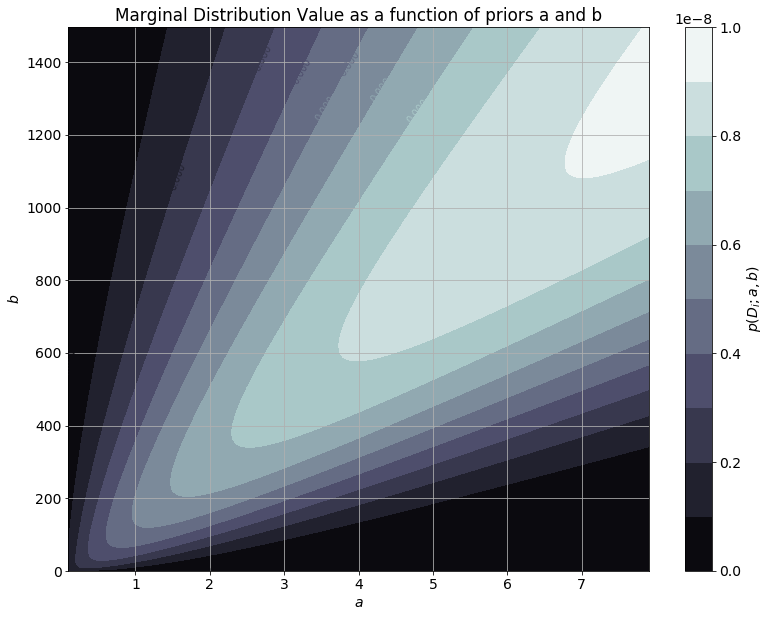

In [11]:
origin = 'lower'
CS = plt.contourf(A, B, Z, 10,
                  cmap=plt.cm.bone,
                  origin=origin)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel(r'$p(D_i;a,b)$')

plt.title('Marginal Distribution Value as a function of priors a and b');

In [12]:
app_data = np.array([[50, 10000],
              [160, 20000],
              [180, 60000],
              [0, 100],
              [0, 5],
              [1, 2]])

log_marginal_all_app = functools.partial(log_marginal_distribution, X=app_data)
a = np.linspace(0.1, 40, 500)
b = np.linspace(1, 3000, 1000)

A, B = np.meshgrid(a, b)
Z = np.array([[log_marginal_all_app(w=([A[i,j],B[i,j]])) for j in range(A.shape[1])] for i in range(A.shape[0])])

In [13]:
np.amax(Z)

-2483.725154330805

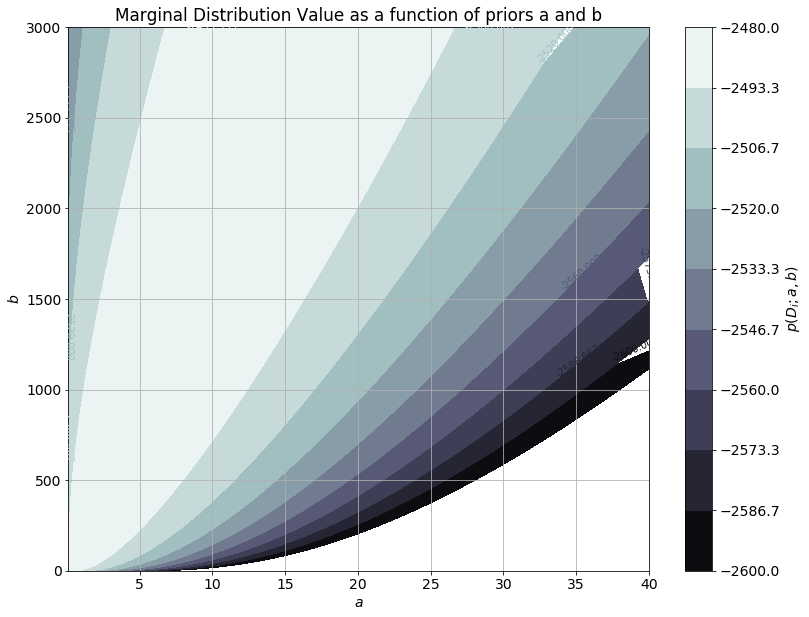

In [14]:
origin = 'lower'
levels = np.linspace(-2600, -2480, 10)
CS = plt.contourf(A, B, Z, levels,
                  cmap=plt.cm.bone,
                  origin=origin)
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel(r'$a$')
plt.ylabel(r'$b$')
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel(r'$p(D_i;a,b)$')

plt.title('Marginal Distribution Value as a function of priors a and b');

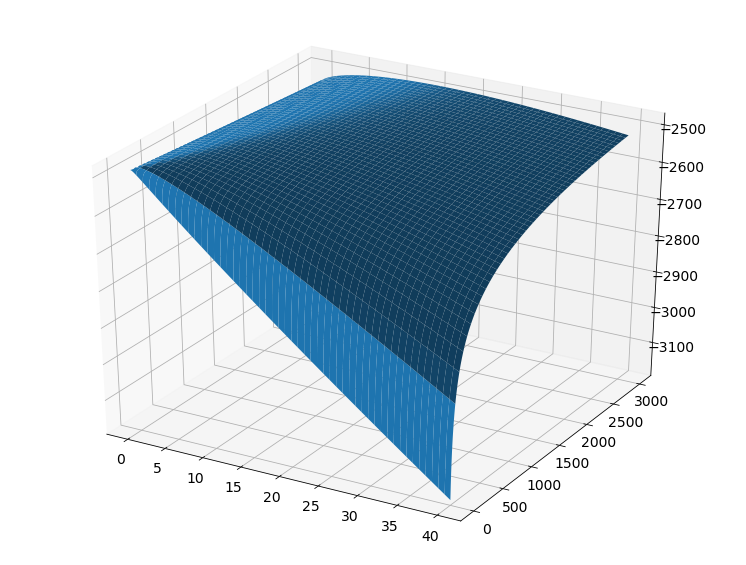

In [15]:
fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');
ax.plot_surface(A,B, Z);

In [16]:
def f_obj(w):
    return -log_marginal_distribution(app_data, w)

w = minimize(f_obj, np.ones((2,1))).x
print(f'The optimal prior parameters for the beta distribution are a = {w[0]:0.4E} and b = {w[1]:0.4E}')
print('The mean of the prior is {0:0.2E}'.format(w[0]/(w.sum())))
print('The variance of the prior is {0:0.2E}'.format(np.sqrt(w.prod()/(w.sum()**2 * (w.sum() + 1)))))

The optimal prior parameters for the beta distribution are a = 2.2477E+00 and b = 3.3642E+02
The mean of the prior is 6.64E-03
The variance of the prior is 4.41E-03


In [17]:
def beta_mle(nx, ny):
    return nx / (nx + ny)

def beta_map(nx, ny, a, b):
    return (nx + a - 1) / (nx + ny + a + b - 2)

def beta_posterior_mean(nx, ny, a, b):
    return (nx + a) / (nx + ny + a + b)

def beta_posterior_var(nx, ny, a, b):
    return (nx + a) * (ny + b) / (nx + a + ny + b) ** 2 / (nx + a + ny + b + 1)

In [18]:
clicks = app_data[:, 0]
impressions = app_data[:, 1]
mle_estimate = beta_mle(clicks, impressions)
map_estimate = beta_map(clicks, impressions, w[0], w[1])
posterior_mean = beta_posterior_mean(clicks, impressions, w[0], w[1])
posterior_var = beta_posterior_var(clicks, impressions, w[0], w[1])

In [19]:
estimate_df = pd.DataFrame(np.vstack((clicks, impressions, mle_estimate, map_estimate, posterior_mean, np.sqrt(posterior_var))).T)
estimate_df.columns = ['clicks', 'impressions', 'MLE', 'MAP', 'PosteriorMean', 'PosteriorStd']
estimate_df

,clicks,impressions,MLE,MAP,PosteriorMean,PosteriorStd
0,50.0,10000.0,0.004975,0.004934,0.005029,0.000694
1,160.0,20000.0,0.007937,0.007867,0.007915,0.000619
2,180.0,60000.0,0.002991,0.002995,0.003011,0.000223
3,0.0,100.0,0.000000,0.002857,0.005124,0.003405
4,0.0,5.0,0.000000,0.003652,0.006540,0.004342
5,1.0,2.0,0.333333,0.006617,0.009505,0.005242


### Problem 8.3

The beta distribution has mean $m = \frac{a}{a+b}$ and variance $v = \frac{ab}{(a+b)^2(a+b+1)}$. To parametrize the beta distribution in terms of its mean and variance we need to solve for both $a$ and $b$ in terms of $m$ and $v$. 

$$
\begin{align*}
v/m &= \frac{b}{(a+b)(a+b+1)}\\
v/(m(1-m))&= \frac{1}{a+b+1}\\
a+b + 1 = m(1-m)/v\\
a &= m(1-m)/v - 1 - b\\
\end{align*}
$$

Plugging this expression for $a$ back into the equation for the mean we have

$$
\begin{align*}
m &= \frac{m(1-m)/v - 1 - b}{m(1-m)/v - 1}\\
m &= 1 - \frac{b}{m(1-m)/v - 1}\\
m^2(1-m)/v - m &= m(1-m)/v - 1 - b\\
b &= m(1-m)/v - 1 - m^2(1-m)/v + m\\
 &= m(1-m)/v(1 - m) - (1-m)\\
 &= \left(m(1-m)/v - 1\right)(1-m)
\end{align*}
$$

Plugging back we find $a$ is 
$$
\begin{align*}
a &= m(1-m)/v - 1 - \left(m(1-m)/v - 1\right)(1-m)\\
&= \left(m(1-m)/v-1\right)\left(1 - (1-m)\right)\\
&= m\left(m(1-m)/v-1\right)\\
\end{align*}
$$

Having defined $\text{B}(\theta;m,v)$ we can place a prior distribution on the mean and variance such a binomial or Poisson as these will give disrete positive values

The final posterior distribution is given by 

$$
\begin{align*}
p(\theta_1, \ldots, \theta_d|\mathcal{D}) &= \frac{p(\mathcal{D}|\theta_1,\ldots,\theta_d)p(\theta_1, \ldots, \theta_d)}{p(\mathcal{D})}\\
&= \frac{p(\mathcal{D}|\theta_1,\ldots,\theta_d)p(\theta_1, \ldots, \theta_d|m,v)p(m,v)}{p(\mathcal{D})}\\
&= \frac{p(\mathcal{D}|\theta_1,\ldots,\theta_d)p(\theta_1, \ldots, \theta_d|m,v)p(m,v)}{\int p(\mathcal{D}|\theta_1,\ldots,\theta_d)p(\theta_1, \ldots, \theta_d|m,v)p(m,v)}
\end{align*}
$$

In the event we just place all the weight on the arg max of the prior distribution $\text{B}(m,v)$ then $p(m,v)=p(m_{MAP},v_{MAP}) = 1$ and the denominator simply becomes a beta function evaluation. In the event we use the full prior, the numerator is easily evaluated but the denominator is intractable.